In [1]:
import pathlib

import e3psi.models
import hubbardml
from hubbardml import keys, plots, similarities
import numpy as np
import torch

import ignite.metrics.metric

hubbardml.utils.random_seed()

dtype = torch.float32
torch.set_default_dtype(dtype)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device, torch.get_default_dtype()

('cuda', torch.float32)

In [2]:
VALIDATE_PERCENTAGE = 0.2
DATASET = "../data/data_uv_unique_inout_2023_2_8.json"

SAVEFIGS = False
TARGET_PARAM = 'U'
DELTA_LEARNING = False

def plotfile(label: str):
    return f'plots/{DATASET}_{label}.pdf'

In [3]:
df = hubbardml.datasets.load(DATASET)

## Input creation

Filter the DF to keep things we want

In [4]:
df = hubbardml.graphs.UGraph.prepare_dataset(df)
species = list(df[keys.ATOM_1_ELEMENT].unique())

graph = hubbardml.graphs.UGraph(species)
print(len(df))

df = similarities.deduplicate(df, graph.get_similarity_frame(df), input_threshold=1e-3)
print(len(df))

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


423


/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


173


## Model creation

In [5]:
model = hubbardml.models.UModel(
    graph,
    feature_irreps="10x0e + 4x2e",
    hidden_layers=2,
    rescaler=hubbardml.models.Rescaler.from_data(df[keys.PARAM_OUT], method="mean"),
    irrep_normalization="norm",
)
model.to(dtype=dtype, device=device)

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


UModel(
  (layers): ModuleList(
    (0): TensorSquare(6x0e+1x2e+1x4e+2x0e+1x1e+1x2e+1x3e+1x4e+1x0e+1x1e+1x2e+1x3e+1x4e+1x5e+1x6e+1x7e+1x8e -> 14x0e+4x2e | 1310 paths | 1310 weights)
    (1): Gate (14x0e+4x2e -> 10x0e+4x2e)
    (2): TensorSquare(10x0e+4x2e -> 14x0e+4x2e | 1110 paths | 1110 weights)
    (3): Gate (14x0e+4x2e -> 10x0e+4x2e)
    (4): TensorSquare(10x0e+4x2e -> 1x0e | 65 paths | 65 weights)
    (5): Rescaler()
  )
)

## Split test/train

In [6]:
hubbardml.datasets.split(df, method='category', frac=0.2, category=[keys.ATOM_1_ELEMENT])

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_1_occs_inv_1,atom_1_occs_inv_2,atom_2_occs_inv_1,atom_2_occs_inv_2,param_delta,species,label,colour,sc_paths,training_label
0,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[[1.24, -0.232, -0.022, -0.012, -0.006], [-0.2...","[[0.3844, 0.013456000000000001, 0.000120999999...","[[1.24, -0.232, -0.022, -0.012, -0.006], [-0.2...","[[0.3844, 0.013456000000000001, 0.000120999999...",10.2709,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
78,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[[1.2550000000000001, 0.187, -0.01399999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...","[[1.2550000000000001, 0.187, -0.01399999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...",9.6452,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
161,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[[1.2550000000000001, 0.187, 0.013999999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...","[[1.2550000000000001, 0.187, 0.013999999999999...","[[0.36365400000000003, 0.008586, 3.29999999999...",9.6452,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
237,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,1,,"[20.4521, 0.0, 0.0, 0.0, 10.1708088779, 0.0, -...",80,luca,1,1.594004e+09,...,"[[1.24, -0.232, 0.022, -0.012, 0.006], [-0.232...","[[0.3844, 0.013456000000000001, 0.000120999999...","[[1.24, -0.232, 0.022, -0.012, 0.006], [-0.232...","[[0.3844, 0.013456000000000001, 0.000120999999...",10.2709,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,validate
706,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,b-type,False,2,,"[20.579721104, 0.0, -0.052459636500000004, 0.0...",80,luca,2,1.597510e+09,...,"[[1.2, -0.298, -0.04, -0.025, -0.01], [-0.298,...","[[0.36, 0.022201, 0.0004, 0.000156, 2.5e-05], ...","[[1.2, -0.298, -0.04, -0.025, -0.01], [-0.298,...","[[0.36, 0.022201, 0.0004, 0.000156, 2.5e-05], ...",-0.7733,(Ni),Ni,#50D050,/Users/azadoks/Data/uv_ml/luca/PrNiO3/by_type/...,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95282,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,1,,"[15.4911, 0.0, 0.0, 0.0, 15.491982992699999, 0...",48,iurii,120,1.637239e+09,...,"[[0.904, -0.002999999999999999, 0.0, -0.006, 0...","[[0.167055, -8.8e-05, -8.099999999999999e-05, ...","[[0.904, -0.002999999999999999, 0.0, -0.006, 0...","[[0.167055, -8.8e-05, -8.099999999999999e-05, ...",0.8820,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,validate
98544,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,2,,"[15.4325, 0.0, 0.0, 0.0, 15.4319598625, 0.0, 0...",48,iurii,121,1.637755e+09,...,"[[0.891, -0.006999999999999999, 0.006999999999...","[[0.17700799999999997, -0.00012, -0.00012, 0.0...","[[0.891, -0.006999999999999999, 0.006999999999...","[[0.17700799999999997, -0.00012, -0.00012, 0.0...",-0.0754,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,train
99337,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,2,,"[15.4325, 0.0, 0.0, 0.0, 15.4319598625, 0.0, 0...",48,iurii,121,1.637755e+09,...,"[[0.898, 0.0, 0.002, 0.005, 0.008], [0.0, 1.07...","[[0.17270100000000002, -0.0001, -9.89999999999...","[[0.898, 0.0, 0.002, 0.005, 0.008], [0.0, 1.07...","[[0.17270100000000002, -0.0001, -9.89999999999...",-0.0833,(Mn),Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,train
102633,/Users/azadoks/Data/uv_ml/iurii/Spinel/LixMn2O...,Mn2O4,False,3,,"[15.4309, 0.0, 0.0, 0.0, 15.430421642099999, 0...",48,iurii,122,1.638445e+09,...,"[[0.8899999999999999, 0.006

In [7]:
# Get the indices of the training and validation data
train_idx = df[df[keys.TRAINING_LABEL] == keys.TRAIN].index
validate_idx = df[df[keys.TRAINING_LABEL] == keys.VALIDATE].index

print(df.loc[train_idx][keys.ATOM_1_ELEMENT].value_counts())
print(df.loc[validate_idx][keys.ATOM_1_ELEMENT].value_counts())

Ni    56
Mn    47
Fe    30
Co     3
Ti     2
Name: atom_1_element, dtype: int64
Ni    14
Mn    12
Fe     8
Co     1
Name: atom_1_element, dtype: int64


In [8]:
trainer = hubbardml.Trainer.from_frame(
    model=model,
    opt=torch.optim.Adam(model.parameters(), lr=0.001),
    loss_fn=torch.nn.MSELoss(),
    frame=df,
    target_column=keys.PARAM_DELTA if DELTA_LEARNING else keys.PARAM_OUT,
)

In [22]:
trainer.overfitting_window = 400

trainer.train(
    callback=lambda trainer: print(trainer.status()),
    callback_period=50,
    max_epochs=1_000,
)

epoch: 900 train: mse 1.92830, valid: mse 1.50121 rmse 1.2252
epoch: 950 train: mse 1.85494, valid: mse 1.52145 rmse 1.2335
epoch: 1000 train: mse 1.80719, valid: mse 1.53724 rmse 1.2399
epoch: 1050 train: mse 1.76454, valid: mse 1.54790 rmse 1.2441
epoch: 1100 train: mse 1.72450, valid: mse 1.55332 rmse 1.2463
epoch: 1150 train: mse 1.68303, valid: mse 1.55337 rmse 1.2463
epoch: 1200 train: mse 1.64343, valid: mse 1.54831 rmse 1.2443
epoch: 1250 train: mse 1.60835, valid: mse 1.53843 rmse 1.2403
epoch: 1300 train: mse 1.57096, valid: mse 1.52724 rmse 1.2358
epoch: 1350 train: mse 1.53655, valid: mse 1.51620 rmse 1.2313
epoch: 1400 train: mse 1.50645, valid: mse 1.50119 rmse 1.2252
epoch: 1450 train: mse 1.47392, valid: mse 1.48272 rmse 1.2177
epoch: 1500 train: mse 1.43967, valid: mse 1.46130 rmse 1.2088
epoch: 1550 train: mse 1.40488, valid: mse 1.43749 rmse 1.1990
epoch: 1600 train: mse 1.37073, valid: mse 1.41180 rmse 1.1882
epoch: 1650 train: mse 1.33685, valid: mse 1.38484 rmse 1

'max_epochs'

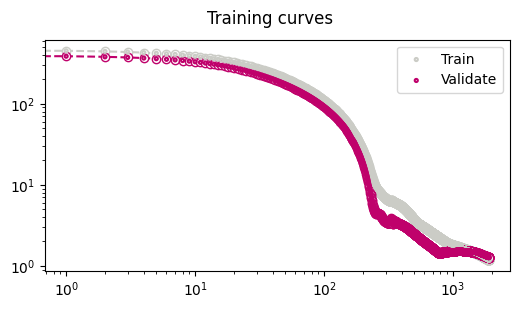

In [23]:
fig = trainer.plot_training_curves();
if SAVEFIGS:
    fig.savefig(plotfile('+U_training'), bbox_inches='tight')
fig.gca().set_xscale("log")

In [14]:
with torch.no_grad():
    train_predicted = hubbardml.engines.evaluate(model, trainer.train_loader).detach().cpu().numpy().reshape(-1)
    val_predicted = hubbardml.engines.evaluate(model, trainer.validate_loader).detach().cpu().numpy().reshape(-1)

df.loc[validate_idx, keys.PARAM_OUT_PREDICTED] = val_predicted
df.loc[train_idx, keys.PARAM_OUT_PREDICTED] = train_predicted

if DELTA_LEARNING:
    df[keys.PARAM_OUT_PREDICTED] += df[keys.PARAM_IN]

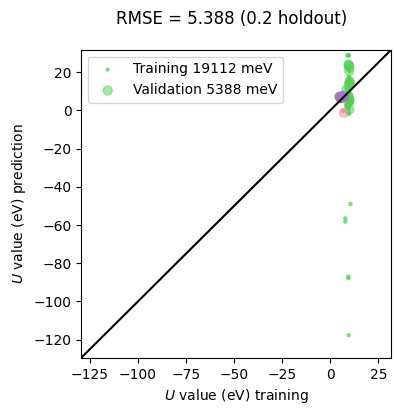

In [15]:
def rmse(y1, y2):
    return np.sqrt(((y1 - y2) ** 2).mean())


df_validate = df.loc[validate_idx]
validate_rmse = hubbardml.datasets.rmse(df_validate)
plots.create_parity_plot(df, title=f'RMSE = {validate_rmse:.3f} ({VALIDATE_PERCENTAGE} holdout)',
                         axis_label=f'${TARGET_PARAM}$ value (eV)');

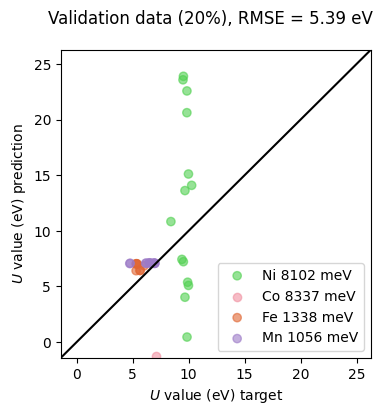

In [16]:
fig = plots.split_plot(df_validate, keys.ATOM_1_ELEMENT,
                       axis_label='$U$ value (eV)',
                       title=f'Validation data ({VALIDATE_PERCENTAGE * 100:.0f}%), RMSE = {validate_rmse:.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('+U_parity_species'), bbox_inches='tight')

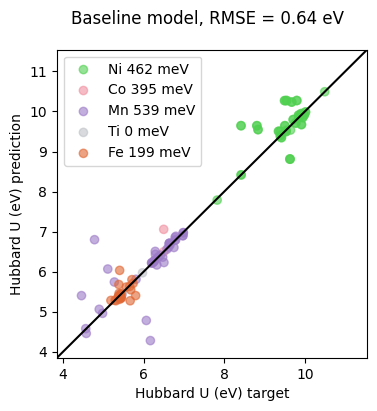

In [17]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(df_ref, keys.ATOM_1_ELEMENT, axis_label=f'Hubbard {TARGET_PARAM} (eV)',
                       title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref):.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

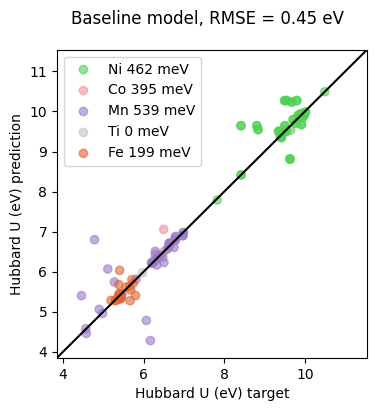

In [18]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(
    df_ref,
    keys.ATOM_1_ELEMENT,
    axis_label=f'Hubbard {TARGET_PARAM} (eV)',
    title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref, label="both"):.2f} eV',
);

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

In [ ]:
{str(pathlib.Path(directory).parent) for directory in df[keys.DIR].unique()}

In [ ]:
max_range = df[keys.PARAM_OUT].max() - df[keys.PARAM_OUT].min()
max_range = max(max_range, (df[keys.PARAM_OUT_PREDICTED].max() - df[keys.PARAM_OUT_PREDICTED].min()))
print(max_range)

plots.create_progression_plots(
    df,
    '/home/azadoks/Projects/uv_ml/data/iurii/Olivines/LiMnPO4/B2_Li0.25MnPO4/DFT_plus_UV',
    yrange=1.2
);

In [ ]:
if SAVEFIGS:
    idx = 0
    for figgroup in res:
        for fig in figgroup.values():
            fig.savefig(f'plots/hubbard_u/steps_{idx}_+U.pdf', bbox_inches='tight')
            idx += 1

In [ ]:
import copy

fig, ax = copy.deepcopy(model.tp1).cpu().visualize()
# ax.get_lines()[0].set_color('black')
for patch in ax.patches:
    patch.set_color(plots.plot_colours[2])

if SAVEFIGS:
    fig.savefig('plots/hubbard_u_tp.pdf', bbox_inches='tight')

In [ ]:
df[df[keys.PARAM_IN] == 0.][keys.TRAINING_LABEL]
